# Bayesian Linear Regression - Toy Example - Based on Bishop's $\S$ 3.3.1
Consider a single variable $x$, a single target variable $t$ and a linear model of the form:
$$y(x,\vec{w})= w_0 + w_1x.$$
Because this has two adaptative parameters, we can plot the prior and posterior distributions directly in parameter space. The dataset we will use for this endeavor is given by:
$$f(x,\vec{a})= a_0 + a_1x,$$
where:
\begin{align*}
a_0&=-0.3,\\
a_1&=0.5,
\end{align*}
the $x_n$ datapoints are to be drawn from a uniform distribution $U(x|-1,1)$, the function $f(x, \vec{a})$ is then evaluated and Gaussian noise with standard deviation of $0.2$ is added to obtain the target values $t_n$. Our goal is to recover the values of $a_0$ and $a_1$ from the synthetic dataset, exploring the dependence on sample size. 

## Synthetic data generation

In [36]:
import sys
sys.path.append('../src/utils/')

In [37]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from plotting import clean_ax

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
plt.style.use('dark_background')

In [38]:
def func(x: float, a: list[float] = [-0.3, 0.5]) -> float:
    """Two parameter linear function to be approximated
    Parameters
    ----------
    x: float,
        real-valued input variable
    a: list[float], (default = [-0.3, 0,5])
        line parameters vector
    Returns
    -------
    f(x): float,
        linear function output
    """
    return a[0]+a[1]*x

In [39]:
# To generate the actual dataset we will create a different function
def get_X_y(low:float = -1, high:float = 1, sample_size: int = 25, random_seed: int = 42):
    """Produces the X and y sample, given the uniform 
    distribution parameters and the sample size
    Parameters
    ----------
    low: float (default = 0.0)
        low limit for uniform distribution
    high: float (default = 1.0)
        hihg limit for uniform distribution
    sample_size: int (default = 25)
        size of the sample to be generated
    random_seed: int (default = 42)
        random state seed

    Returns
    -------
    X: list[float]
        Covariate samples
    y: list[float]
        Response variable samples
    """
    np.random.seed(random_seed)
    X = np.random.uniform(low, high, sample_size) 
    y = func(X) + np.random.normal(0, 0.2, size = sample_size)
    return X, y

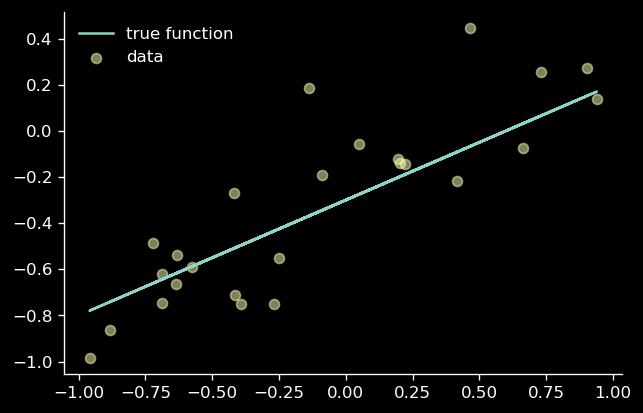

In [40]:
sample_size = 25
X, y = get_X_y(sample_size=sample_size)
t = np.apply_along_axis(func, 0, X)
f, ax = plt.subplots(dpi=120)
ax.plot(X, t, label='true function')
ax.scatter(X,y, c='C1', marker='o', alpha=0.5, label='data')
ax.legend(loc='best', frameon=False)
clean_ax(ax)
plt.show()

Next step is to build the prior distribution for the parameters $\vec{w}$, which we will take to be given by:
$$p(\vec{w}|\alpha) = \mathcal{N}(\vec{w}|\mathbf{0}, \alpha^{-1}\mathbf{I}),$$
for that we can use the `numpy.random.multivariate_normal` method. In the following cell we illustrate the process of sampling the parameters from the prior distribution and plotting the resulting model (line), we do that five times to obtaing five straight lines:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


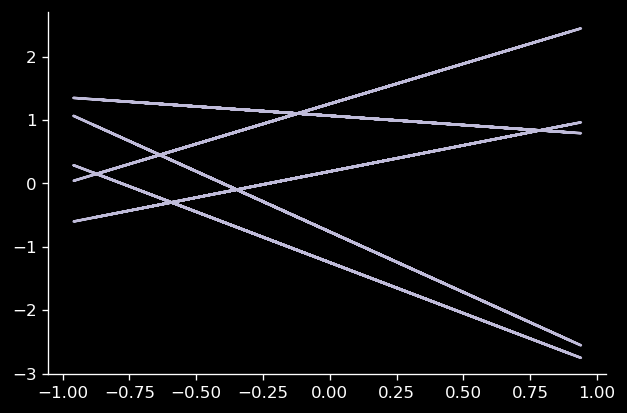

In [41]:
mu=[0.0, 0.0]
alpha=2.0
beta=(1/alpha)**2
cov=alpha*np.eye(2)
f, ax = plt.subplots(dpi=120)
for i in range(5):
    a= np.random.multivariate_normal(mean=mu,cov=cov)
    s= func(X, a)
    ax.plot(X,s, c='C2')
# ax.scatter(X,y, c='C1', marker='o', alpha=0.5, label='data')
ax.legend(loc='best', frameon=False)    
clean_ax(ax)
plt.show()

# Posterior distribution

Now, we need to implement the process of updating the parameter distribution after *observing* a data point. We would like to do this in a sequential way, this is, one data point at a time. Recall that we are considering a Gaussian prior of the form:
$$p(\vec{w}|\alpha) = \mathcal{N}(\vec{w}|\mathbf{0}, \alpha^{-1}\mathbf{I}),$$
the posterior distribution is given by:
$$p(\vec{w}|\mathbf{t}) = \mathcal{N}(\vec{w}|\mathbf{m}_N, \mathbf{S}_N),$$
where
\begin{align}
\mathbf{m}_N &=  \beta\mathbf{S}_N\mathbf{\Phi}^T\mathbf{t}\\
\mathbf{S}_N^{-1} &= \alpha\mathbf{I} + \beta \mathbf{\Phi}^T \mathbf{\Phi}
\end{align}

For the single input case we are handling in this example, the design matrix $\mathbf{\Phi}$ has the form:

\begin{align}\mathbf{\Phi} = 
\begin{pmatrix}
1 & x_1\\ 
1 & x_2 \\
\vdots & \vdots \\ 
1 & x_N 

\end{pmatrix}
\end{align}

We will begin by computing the posterior distribution parameters $m_N$ and covariance matrix using the complete dataset:

In [42]:
# let us construct the inverse S_N matrix for the entire dataset
phi = np.array([[1, x] for x in X])
S_N_inv = alpha*np.eye(2) + beta* np.dot(phi.T, phi)
# Find the inverse
S_N = np.linalg.inv(S_N_inv)

In [43]:
# check the inverse is ok
np.dot(S_N, S_N_inv)

array([[1.00000000e+00, 2.40376340e-18],
       [8.04244587e-18, 1.00000000e+00]])

In [44]:
# compute the mean
m_N = beta * np.dot(S_N, np.dot(phi.T, t))
m_N

array([-0.24863139,  0.26188475])

In [45]:
# Sample from the posterior distribution
a= np.random.multivariate_normal(mean=m_N,cov=S_N)
s= func(X, a)

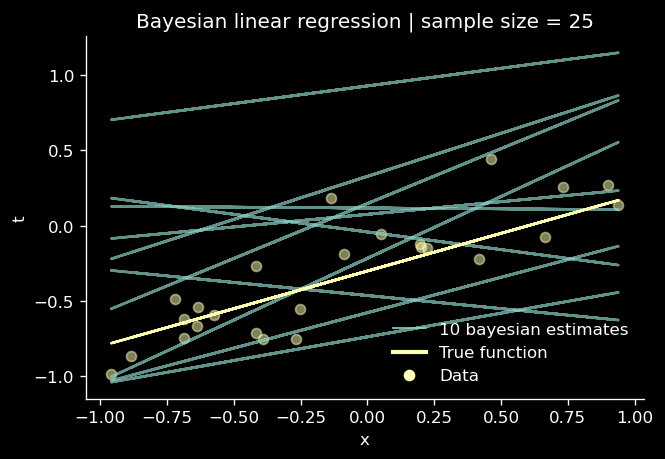

In [46]:
# Plot the resulting line
f, ax = plt.subplots(dpi=120)
for i in range(10):
    # Sample from the posterior distribution
    a= np.random.multivariate_normal(mean=m_N,cov=S_N)
    s= func(X, a)
    ax.plot(X, s, c='C0', alpha=0.7)
ax.plot(X, t, c='C1')
ax.scatter(X,y, c='C1', marker='o', alpha=0.5, label='data')
legend_elements = [
    Line2D([0], [0], color='C0', lw=1, label='10 bayesian estimates'),
    Line2D([0], [0], color='C1', lw=2.5, label='True function'),
    Line2D([0], [0], marker='o', color='k', label='Data',
           markerfacecolor='C1', markersize=8),
                          ]
ax.legend(handles=legend_elements, loc='best', frameon=False)
ax.set_title(f'Bayesian linear regression | sample size = {sample_size}')
ax.set_xlabel('x')
ax.set_ylabel('t')
clean_ax(ax)
plt.show()

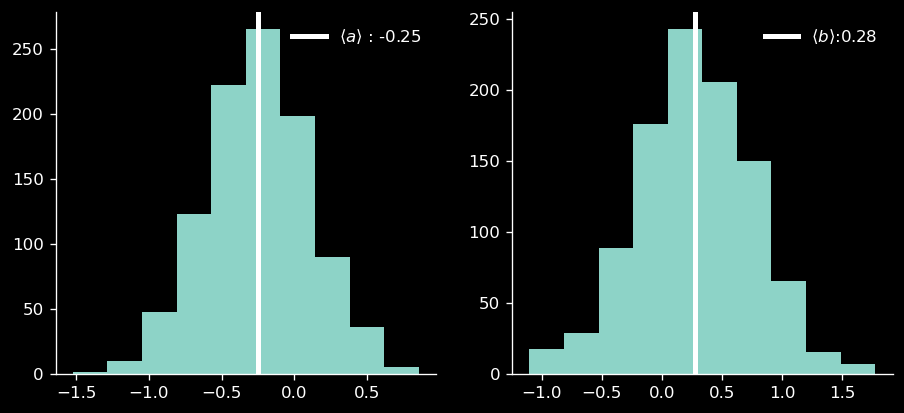

In [47]:
a_rand = np.random.multivariate_normal(mean=m_N, cov=S_N, size=int(1e3))
a_rand

f, ax = plt.subplots(1, 2, dpi=120, figsize=(9,4))
ax[0].hist(a_rand[:,0])
ax[0].axvline(np.mean(a_rand[:,0]), label=r'$\langle a\rangle$ ' +f': {np.mean(a_rand[:,0]):.2f}', lw=3)
ax[0].legend(loc='best', frameon=False)
clean_ax(ax[0])

ax[1].hist(a_rand[:,1])
ax[1].axvline(np.mean(a_rand[:,1]), label=r'$\langle b\rangle$'+  f':{np.mean(a_rand[:,1]):.2f}', lw=3)
ax[1].legend(loc='best', frameon=False)
clean_ax(ax[1])
plt.show()

# Bigger sample test


In [48]:
def get_posterior_parameters(X: np.array, y: np.array, alpha: float= 2.0, beta: float = (1/alpha)**2):
    """
    """
    # Construct the inverse S_N matrix for the entire dataset
    phi = np.array([[1, x] for x in X])
    S_N_inv = alpha*np.eye(2) + beta* np.dot(phi.T, phi)
    # Find the inverse
    S_N = np.linalg.inv(S_N_inv)
    # compute the mean
    m_N = beta * np.dot(S_N, np.dot(phi.T, t))
    return m_N, S_N

def sample_parameters_from_posterior(m_N, S_N):
    """
    """
    a = np.random.multivariate_normal(mean=m_N,cov=S_N)
    return a


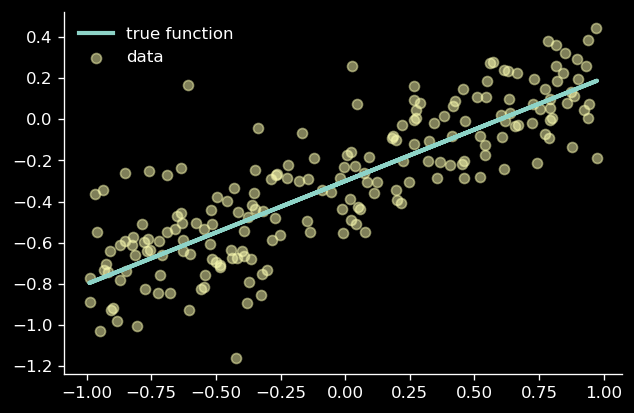

In [49]:
sample_size = 200
X, y = get_X_y(sample_size=sample_size)
t = np.apply_along_axis(func, 0, X)
f, ax = plt.subplots(dpi=120)
ax.plot(X, t, label='true function', lw=2.5,)
ax.scatter(X,y, c='C1', marker='o', alpha=0.5, label='data')
ax.legend(loc='best', frameon=False)
clean_ax(ax)
plt.show()

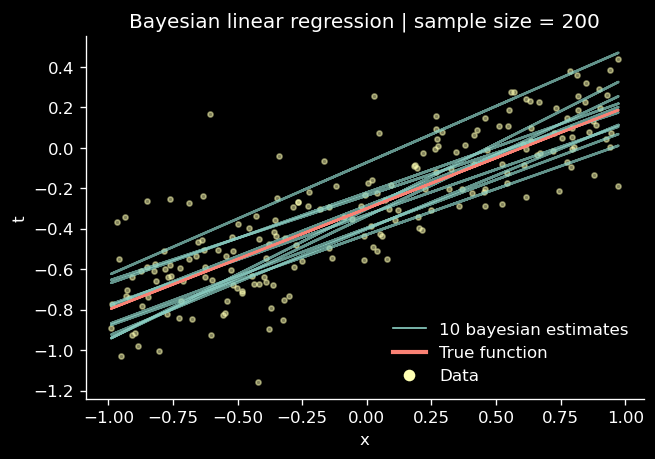

In [50]:
# get posterior parameters
m_N, S_N = get_posterior_parameters(X=X, y=y)
# Plot the resulting line
f, ax = plt.subplots(dpi=120)
for i in range(10):
    # Sample from the posterior distribution
    a= sample_parameters_from_posterior(m_N,S_N)
    s= func(X, a)
    ax.plot(X, s, c='C0', alpha=0.7)
ax.plot(X, t, c='C3')
ax.scatter(X,y, c='C1', marker='.', alpha=0.5, label='data')
legend_elements = [
    Line2D([0], [0], color='C0', lw=1, label='10 bayesian estimates'),
    Line2D([0], [0], color='C3', lw=2.5, label='True function'),
    Line2D([0], [0], marker='o', color='k', label='Data',
           markerfacecolor='C1', markersize=8),
                          ]
ax.legend(handles=legend_elements, loc='best', frameon=False)
ax.set_title(f'Bayesian linear regression | sample size = {sample_size}')
ax.set_xlabel('x')
ax.set_ylabel('t')
clean_ax(ax)
plt.show()

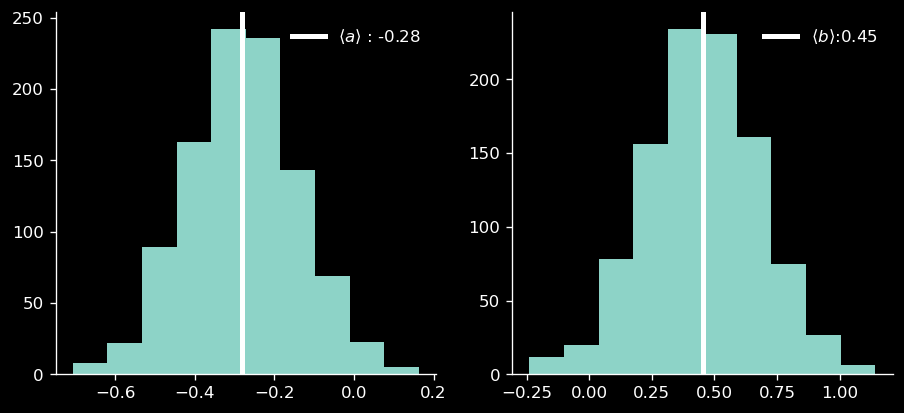

In [51]:
a_rand = np.random.multivariate_normal(mean=m_N, cov=S_N, size=int(1e3))

f, ax = plt.subplots(1, 2, dpi=120, figsize=(9,4))
ax[0].hist(a_rand[:,0])
ax[0].axvline(np.mean(a_rand[:,0]), label=r'$\langle a\rangle$ ' +f': {np.mean(a_rand[:,0]):.2f}', lw=3)
ax[0].legend(loc='best', frameon=False)
clean_ax(ax[0])

ax[1].hist(a_rand[:,1])
ax[1].axvline(np.mean(a_rand[:,1]), label=r'$\langle b\rangle$'+  f':{np.mean(a_rand[:,1]):.2f}', lw=3)
ax[1].legend(loc='best', frameon=False)
clean_ax(ax[1])
plt.show()